In [1]:
import h5py
import json
import numpy as np
import os
import sys
from matplotlib import pyplot as plt

rootFolder = '/home/fernando/S1_netpyne/sim/'
# rootFolder = os.getcwd()
os.chdir(rootFolder)
print(rootFolder)
folder = os.listdir('cell_data/')
folder = sorted(folder)

savedata = 1 # Save Netpyne and BBP soma_voltage

/home/fernando/S1_netpyne/sim/


In [2]:
# !nrnivmodl mod

In [3]:
folder[265:270]

['L23_PC_cADpyr229_1',
 'L23_PC_cADpyr229_2',
 'L23_PC_cADpyr229_3',
 'L23_PC_cADpyr229_4',
 'L23_PC_cADpyr229_5']

In [4]:
def loadTemplateName(cellnumber):     
    f = open(outFolder+'/template.hoc', 'r')
    for line in f.readlines():
        if 'begintemplate' in line:
            templatename = str(line)     
    templatename=templatename[:-1]        
    templatename=templatename[14:]
    return templatename

In [5]:
def runneuron(cellnumber):
        
    os.chdir(rootFolder)
    
    cellName = folder[cellnumber]
    cellTemplateName = loadTemplateName(cellnumber)

    from cellwrapper2 import loadCell #StochKv.mod
    cell=loadCell(cellName, cellTemplateName)

    soma = cell.soma[0]

    BBPTraces = []
    BBPTracesList = []

    i=0
    for x in ampstim:
        i=i+1   
        
        stimulus = neuron.h.IClamp(0.5, sec=soma)

        stimulus.dur = durationstim # ms
        stimulus.delay = delaystim  # ms         
        stimulus.amp = x

        recordings = {}

        recordings['time'] = neuron.h.Vector()
        recordings['soma(0.5)'] = neuron.h.Vector()

        recordings['time'].record(neuron.h._ref_t, 0.1)
        recordings['soma(0.5)'].record(cell.soma[0](0.5)._ref_v, 0.1)

        neuron.h.dt = 0.05
        neuron.h.cvode_active(0)
        neuron.h.tstop = timesimulation # ms
        neuron.h.run();

        time = np.array(recordings['time'])
        soma_voltage = np.array(recordings['soma(0.5)'])

        BBPTraces.append(soma_voltage)
        BBPTracesList.append(list(soma_voltage))
    return BBPTraces

In [6]:
def runnetpyne(cellnumber):

    os.chdir(rootFolder)
    from netpyne import sim
    from netpyne import specs
    import pickle

    cfg = specs.SimConfig()     
    
    cfg.duration = timesimulation ## Duration of the sim, in ms  
    cfg.dt = 0.05
    # ~ cfg.seeds = {'conn': 4321, 'stim': 1234, 'loc': 4321} 
    cfg.hParams = {'celsius': 34, 'v_init': -65}  
    cfg.verbose = False
    cfg.createNEURONObj = True
    cfg.createPyStruct = True
    cfg.cvode_active = False
    cfg.cvode_atol = 1e-6
    cfg.cache_efficient = True
    cfg.printRunTime = 0.5
    
    cfg.includeParamsLabel = False
    cfg.printPopAvgRates = True
    cfg.checkErrors = False
    
    allpops = ['L1_1','L1_2','L1_3','L1_4']

    cfg.recordCells = allpops  # which cells to record from
    cfg.recordTraces = {'V_soma': {'sec':'soma_0', 'loc':0.5, 'var':'v'}}  ## Dict with traces to record
    cfg.recordStim = True
    cfg.recordTime = True
    cfg.recordStep = 0.1            

    cfg.simLabel = 'S1detailed'
    cfg.saveFolder = '.'
    # cfg.filename =                	## Set file output name
    cfg.savePickle = False         	## Save pkl file
    cfg.saveJson = False           	## Save json file
    cfg.saveDataInclude = ['simConfig', 'netParams'] ## 'simData' , 'simConfig', 'netParams'
    cfg.backupCfgFile = None 		##  
    cfg.gatherOnlySimData = False	##  
    cfg.saveCellSecs = False			##  
    cfg.saveCellConns = False		##  

    #------------------------------------------------------------------------------
    # Current inputs 
    #------------------------------------------------------------------------------
    cfg.addIClamp = True

    cfg.IClamp = []
    cfg.IClampnumber = 0
    
    for popName in allpops:
        cfg.IClamp.append({'pop': popName, 'sec': 'soma_0', 'loc': 0.5, 'start': delaystim, 'dur': durationstim, 'amp': ampstim[cfg.IClampnumber]}) #pA
        cfg.IClampnumber=cfg.IClampnumber+1

    netParams = specs.NetParams()   # object of class NetParams to store the network parameters

    #------------------------------------------------------------------------------
    # Cell parameters
    #------------------------------------------------------------------------------
    #StochKv_deterministic.mod
    cellName = folder[cellnumber]
    cellTemplateName = loadTemplateName(cellnumber)
    cellRule = netParams.importCellParams(label=cellName + '_rule', somaAtOrigin=False,
        conds={'cellType': cellName, 'cellModel': 'HH_full'},
        fileName='cellwrapper3.py',
        cellName='loadCell',
        cellInstance = True,
        cellArgs={'cellName': cellName, 'cellTemplateName': cellTemplateName})

    #------------------------------------------------------------------------------
    # Population parameters
    #------------------------------------------------------------------------------

    netParams.popParams['L1_1'] = {'cellType': cellName, 'cellModel': 'HH_full', 'numCells': 1} 
    netParams.popParams['L1_2'] = {'cellType': cellName, 'cellModel': 'HH_full', 'numCells': 1} 
    netParams.popParams['L1_3'] = {'cellType': cellName, 'cellModel': 'HH_full', 'numCells': 1} 
    netParams.popParams['L1_4'] = {'cellType': cellName, 'cellModel': 'HH_full', 'numCells': 1} 

    #------------------------------------------------------------------------------
    # Current inputs (IClamp)
    #------------------------------------------------------------------------------
    for j in range(cfg.IClampnumber):
        key ='IClamp'
        params = getattr(cfg, key, None)
        key ='IClamp'+str(j+1)
        params = params[j]
        [pop,sec,loc,start,dur,amp] = [params[s] for s in ['pop','sec','loc','start','dur','amp']]

        # add stim source
        netParams.stimSourceParams[key] = {'type': 'IClamp', 'delay': start, 'dur': dur, 'amp': amp}
        
        # connect stim source to target
        netParams.stimTargetParams[key+'_'+pop] =  {
            'source': key, 
            'conds': {'pop': pop},
            'sec': sec, 
            'loc': loc}
    
    #------------------------------------------------------------------------------
    sim.createSimulateAnalyze(netParams, cfg)
    
    netpyneTraces = []
    netpyneTracesList = []
    for c in range(0,4):
        netpyneTraces.append(np.array(sim.simData['V_soma']['cell_'+ str(c)]))
        netpyneTracesList.append(list(sim.simData['V_soma']['cell_'+ str(c)]))        
 
    return netpyneTraces

In [7]:
folder[269]

'L23_PC_cADpyr229_5'

CellNumber = 267
CellName = L23_PC_cADpyr229_3
TemplateName = cADpyr229_L23_PC_863902f300
Loading constants
Setting temperature to 34.000000 C
Setting simulation time step to 0.025000 ms
	1 
	1 
	1 
Loading cell cADpyr229_L23_PC_863902f300
cADpyr229_L23_PC_863902f300[0]
Changed dt
Changed dt
Changed dt
Changed dt
cADpyr229_L23_PC_863902f300[0]

Start time:  2021-07-28 21:34:47.209171

Creating network of 4 cell populations on 1 hosts...
  Number of cells on node 0: 4 
  Done; cell creation time = 0.13 s.
Making connections...
  Number of connections on node 0: 0 
  Done; cell connection time = 0.00 s.
Adding stims...
  Number of stims on node 0: 4 
  Done; cell stims creation time = 0.00 s.
Recording 8 traces of 2 types on node 0
0.0s

Running simulation for 3000.0 ms...
0.5s
1.0s
1.5s
2.0s
2.5s
3.0s
  Done; run time = 18.96 s; real-time ratio: 0.16.

Gathering data...
  Done; gather time = 0.01 s.

Analyzing...
  Cells: 4
  Connections: 0 (0.00 per cell)
  Spikes: 88 (7.33 Hz)
  Simul

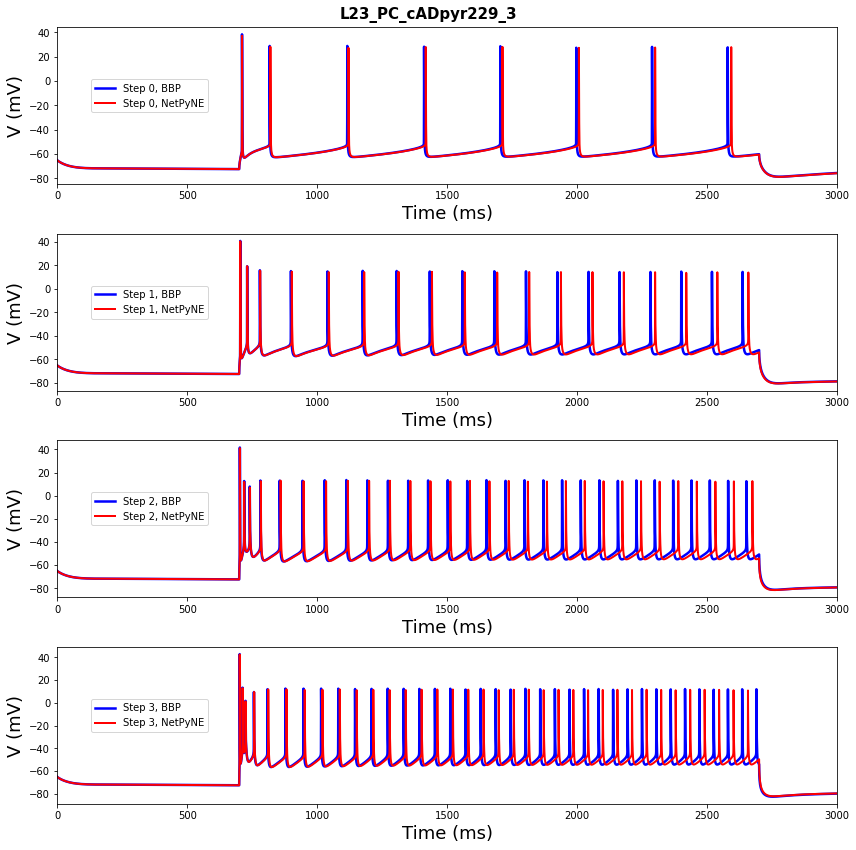

In [8]:
cellnumber = 267 #916 #369 # 267 #
cellName = folder[cellnumber]
outFolder = rootFolder+'/cell_data/'+folder[cellnumber]
cellTemplateName = loadTemplateName(cellnumber)
print ("CellNumber = %d" % cellnumber)
print ("CellName = %s" % cellName)
print ("TemplateName = %s" % cellTemplateName)

ampstim =  [0.2 ,0.4, 0.6, 0.8]

durationstim = 2000
delaystim = 700
timesimulation = 3000
        
BBPTraces = runneuron(cellnumber)
netpyneTraces = runnetpyne(cellnumber)
# plot both traces overlayed
fontsiz=18
timeRange = [0, timesimulation]
recordStep = 0.1
# ~ ylim = [-100, 40]
figSize = (12,12)
fig = plt.figure(figsize=figSize)  # Open a new figure

fig.suptitle('%s' % (cellName), fontsize=15, fontweight='bold')
                
t = np.arange(timeRange[0], timeRange[1]+recordStep, recordStep) 
 
for c in range(0,4):
    netpyneTrace = netpyneTraces[c]
    BBPTrace = BBPTraces[c]
    plt.subplot(4, 1, c+1)
    plt.ylabel('V (mV)', fontsize=fontsiz)
    plt.plot(t[:len(BBPTrace)], BBPTrace, linewidth=2.5, color='blue', label='Step %d'%(int(c+0))+', BBP')  # linestyle=':'
    plt.plot(t[:len(netpyneTrace)], netpyneTrace, linewidth=2.0, color='red', label='Step %d'%(int(c+0))+', NetPyNE')
    plt.xlabel('Time (ms)', fontsize=fontsiz)
    plt.xlim(0, timesimulation)
    # ~ plt.ylim(ylim)
    plt.grid(False)
    plt.legend(loc='upper right', bbox_to_anchor=(0.20, 0.7))
plt.ion()
plt.tight_layout()
os.chdir(rootFolder)
os.chdir('../info/scripts_comparations/')
plt.savefig('Figures-comparation/comparison_traces_soma_voltage_4steps_%s.png' % cellName, facecolor = 'white' , dpi=300)
print ("Figure Saved in %s/comparison_traces_soma_voltage_4steps_%s.png" % (rootFolder,cellName))
print ("https://bbp.epfl.ch/nmc-portal/microcircuit.html#/metype/%s/details" % cellName[:-5])
plt.show()

## Efel

In [9]:
import efel

In [10]:
traces = []
traces2 = []
for c in range(4):
    BBPTrace = BBPTraces[c]
    trace = {}
    trace['T'] = t[:len(BBPTrace)]
    trace['V'] = BBPTrace
    trace['stim_start'] = [delaystim]
    trace['stim_end'] = [delaystim+durationstim]
    traces.append(trace)
    
    netpyneTrace = netpyneTraces[c]
    trace2 = {}
    trace2['T'] = t[:len(netpyneTrace)]
    trace2['V'] = netpyneTrace
    trace2['stim_start'] = [delaystim]
    trace2['stim_end'] = [delaystim+durationstim]
    traces2.append(trace2)

In [11]:
np.mean(trace['V'][6990:7000])

-72.34286394549713

In [12]:
np.mean(trace2['V'][6990:7000])

-72.34285498338204

In [13]:
feature_items = ['mean_frequency', 'ISI_CV', 'time_to_first_spike', 'time_to_second_spike', 'AP_height', 'AP_width', 'AP_amplitude']
feature_values = efel.getFeatureValues(traces, feature_items)
feature_values2 = efel.getFeatureValues(traces2, feature_items)

In [14]:
feature_efel = {}
feature_efel['BBP'] = {}
feature_efel['BBP'][cellName] = {}
feature_efel['NetPyNE'] = {}
feature_efel['NetPyNE'][cellName] = {}
for feature_name in feature_items:
    feature_efel['BBP'][cellName][feature_name]= {}
    feature_efel['NetPyNE'][cellName][feature_name]= {}
    for step_number in range(4):
        feature_efel['BBP'][cellName][feature_name][ampstim[step_number]] = {}
        feature_efel['NetPyNE'][cellName][feature_name][ampstim[step_number]] = {}

feature_name = 'voltage_base' 
feature_efel['BBP'][cellName][feature_name]= {}
feature_efel['NetPyNE'][cellName][feature_name]= {}
for step_number in range(4):
    feature_efel['BBP'][cellName][feature_name][ampstim[step_number]] = {}
    feature_efel['NetPyNE'][cellName][feature_name][ampstim[step_number]] = {}   


In [15]:
for step_number in range(4):
    for feature_name in feature_items:
#         print ("%s: %.4f" % (feature_name, feature_values[step_number][feature_name][0]))
        feature_efel['BBP'][cellName][feature_name][ampstim[step_number]] = feature_values[step_number][feature_name][0] 
        feature_efel['NetPyNE'][cellName][feature_name][ampstim[step_number]] = feature_values2[step_number][feature_name][0] 
    feature_efel['BBP'][cellName]['voltage_base'][ampstim[step_number]] = np.mean(trace['V'][6900:7000]) 
    feature_efel['NetPyNE'][cellName]['voltage_base'][ampstim[step_number]] = np.mean(trace2['V'][6900:7000])

In [16]:
import json

os.chdir(rootFolder)
os.chdir('../info/scripts_comparations/')

with open('Figures-comparation/info_efel_4steps_BBP_NetPyNE_%s.json' % cellName, 'w') as outfile:
    json.dump(feature_efel, outfile)

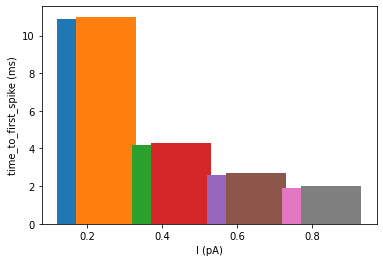

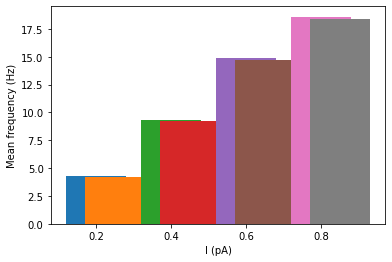

In [17]:
import pylab
for step_number in range(4):
    pylab.bar(step_number, feature_values[step_number]['time_to_first_spike'][0], align='center')
    pylab.bar(step_number+0.25, feature_values2[step_number]['time_to_first_spike'][0], align='center')
pylab.ylabel('time_to_first_spike (ms)')
pylab.xlabel('I (pA)')
pylab.xticks(range(4), ampstim)
pylab.show()

for step_number in range(4):
    pylab.bar(step_number, feature_values[step_number]['mean_frequency'][0], align='center')
    pylab.bar(step_number+0.25, feature_values2[step_number]['mean_frequency'][0], align='center')
pylab.ylabel('Mean frequency (Hz)')
pylab.xlabel('I (pA)')
pylab.xticks(range(4), ampstim)
pylab.show()
